# Cat vs Dog Classifier

In [ ]:
%pip install bing-image-downloader

In [1]:
import os
import requests

import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr

import numpy as np
import utils.SyncTool as sync

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-05-28 17:05:19.530099: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 17:05:19.559986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 17:05:20.039079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU is available


2024-05-28 17:05:20.773735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:05:20.805520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:05:20.805625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Download images

In [2]:
image_path = "./data/cat_dogs/"

In [ ]:
def download_images(query, limit, output_dir):
    
    downloader.download(query,
                        limit=limit,
                        output_dir=output_dir,
                        adult_filter_off=True,
                        force_replace=False,
                        timeout=60)

download_images("cat", 100, image_path)
download_images("dog", 100, image_path)

### Check the downloaded images

In [3]:
for category in ["cat","dog"]:
    data_dir = os.path.join(image_path, category)
    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

**Delete any invalid images**

## Model Training

### Define parameters

In [4]:
# Define hyperparameters and input data
learning_rate = 0.02
num_epochs = 10
batch_size = 32
input_shape = (224, 224, 3)
expno = 1

In [5]:
# Define names for tensorboard logging and mlflow
experiment_name = "cat-dog-classifier"
run_name = f"Experiment_{expno}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

### Read Data

In [6]:
# Load the dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 186 files belonging to 2 classes.
Using 149 files for training.


2024-05-28 17:06:20.679094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:06:20.679183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:06:20.679204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:06:20.827276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 17:06:20.827373: I tensorflow/compile

In [7]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 186 files belonging to 2 classes.
Using 37 files for validation.


Look at some sample images from the datasets

2024-05-28 17:06:26.921439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [149]
	 [[{{node Placeholder/_0}}]]
2024-05-28 17:06:26.921725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [149]
	 [[{{node Placeholder/_4}}]]
2024-05-28 17:06:26.956771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


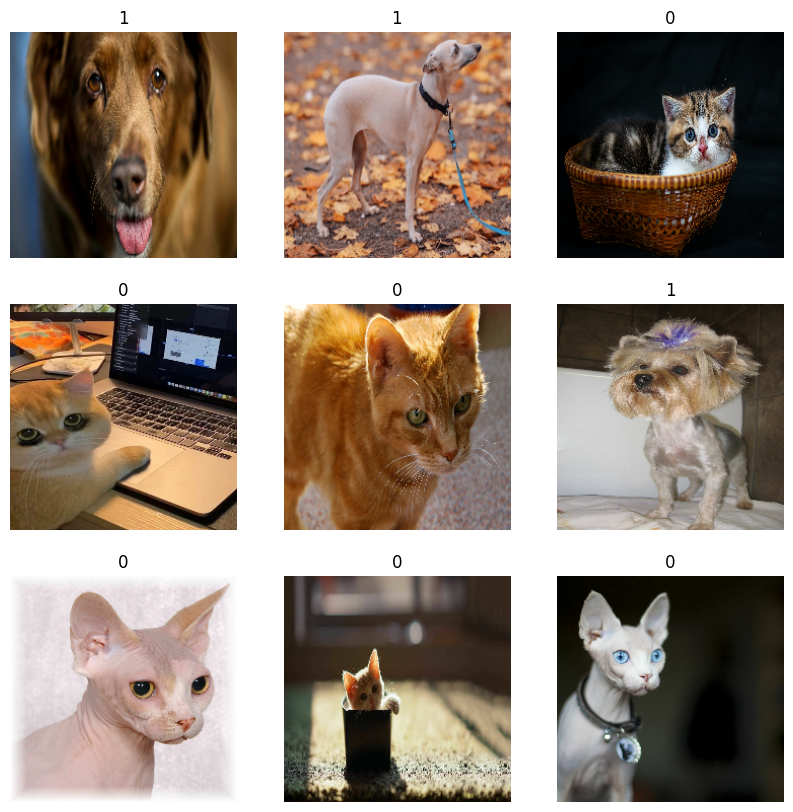

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

2024-05-28 17:06:31.397674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [37]
	 [[{{node Placeholder/_4}}]]
2024-05-28 17:06:31.397902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [37]
	 [[{{node Placeholder/_4}}]]


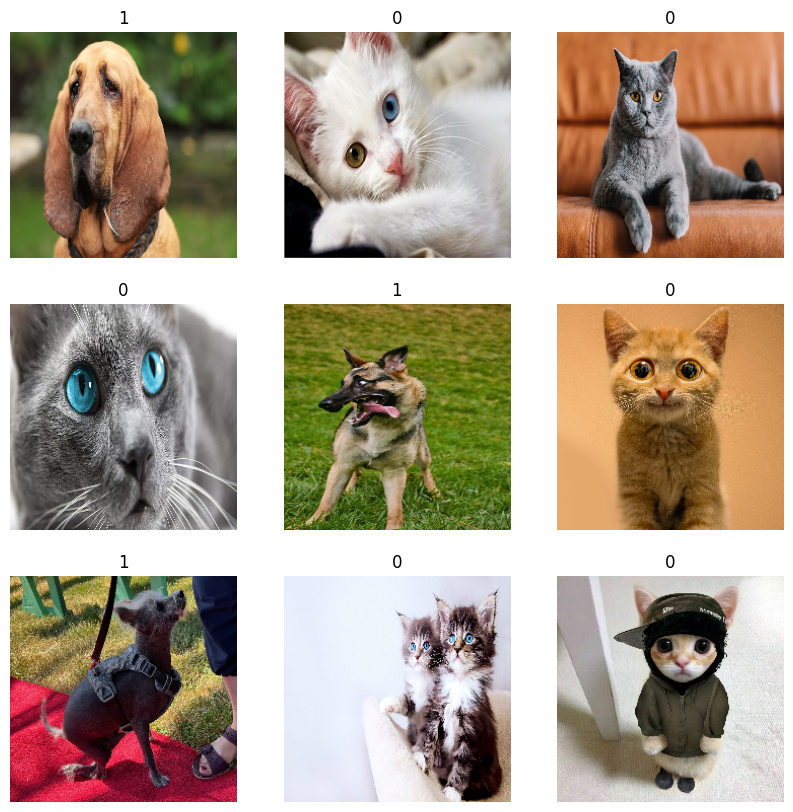

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data Augmentation

In [10]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

2024-05-28 17:06:39.782447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [149]
	 [[{{node Placeholder/_0}}]]
2024-05-28 17:06:39.782724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [149]
	 [[{{node Placeholder/_0}}]]
2024-05-28 17:06:39.795453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


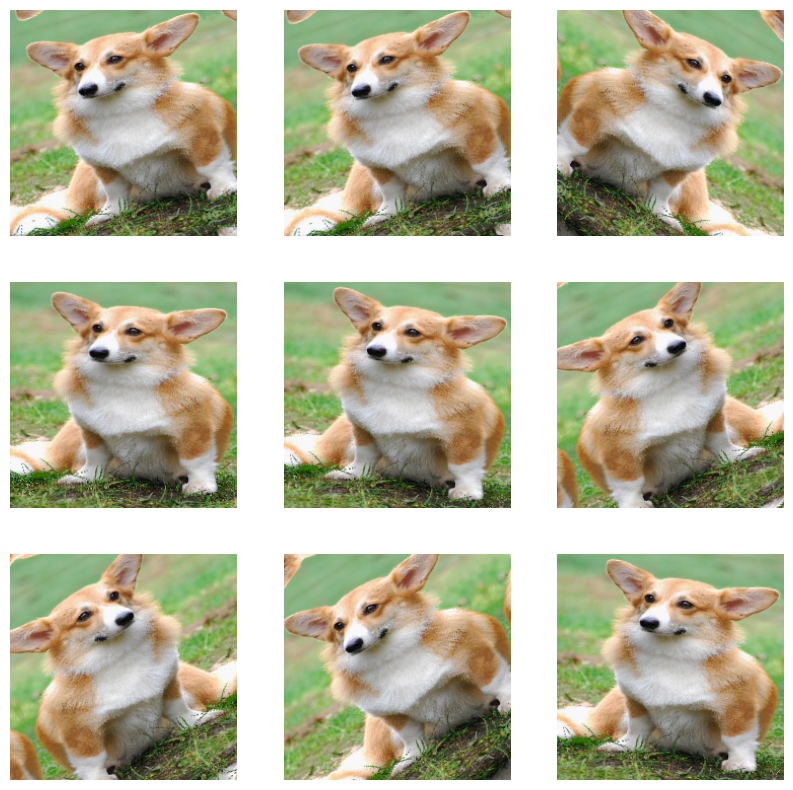

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

### Define Model and Train

In [13]:
# Define the base model and add a classifier on top
base_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

In [15]:
 # Compile the model with a loss function and optimizer
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [16]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [17]:
# Train the model and log metrics and the model itself to MLflow
history = model.fit(
    augmented_train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/10


2024-05-28 17:07:17.290137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]
2024-05-28 17:07:17.290388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2024-05-28 17:07:18.152935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-05-28 17:07:18.786139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-05-28 17:07:18.984119: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling b

5/5 - 4s - loss: 12.8947 - accuracy: 0.5235 - val_loss: 7.4324 - val_accuracy: 0.5946 - 4s/epoch - 789ms/step
Epoch 2/10


2024-05-28 17:07:21.365580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 3.9239 - accuracy: 0.5034 - val_loss: 1.9203 - val_accuracy: 0.4054 - 2s/epoch - 322ms/step
Epoch 3/10


2024-05-28 17:07:23.003546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.8272 - accuracy: 0.5302 - val_loss: 0.6261 - val_accuracy: 0.7568 - 2s/epoch - 339ms/step
Epoch 4/10


2024-05-28 17:07:24.730045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6588 - accuracy: 0.6913 - val_loss: 0.6527 - val_accuracy: 0.7838 - 2s/epoch - 348ms/step
Epoch 5/10


2024-05-28 17:07:26.497767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6525 - accuracy: 0.7114 - val_loss: 0.6323 - val_accuracy: 0.7297 - 2s/epoch - 347ms/step
Epoch 6/10


2024-05-28 17:07:28.269785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6539 - accuracy: 0.6443 - val_loss: 0.6121 - val_accuracy: 0.7027 - 2s/epoch - 343ms/step
Epoch 7/10


2024-05-28 17:07:30.020472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6365 - accuracy: 0.5839 - val_loss: 0.6013 - val_accuracy: 0.7027 - 2s/epoch - 365ms/step
Epoch 8/10


2024-05-28 17:07:31.874889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6232 - accuracy: 0.6174 - val_loss: 0.5935 - val_accuracy: 0.7297 - 2s/epoch - 349ms/step
Epoch 9/10


2024-05-28 17:07:33.654506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.6074 - accuracy: 0.7651 - val_loss: 0.6044 - val_accuracy: 0.7568 - 2s/epoch - 347ms/step
Epoch 10/10


2024-05-28 17:07:35.420005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 2s - loss: 0.5795 - accuracy: 0.8255 - val_loss: 0.5678 - val_accuracy: 0.7297 - 2s/epoch - 353ms/step


## MLFLow Logging and Visualization

2024/05/28 17:08:18 INFO mlflow.tracking.fluent: Experiment with name 'cat-dog-classifier' does not exist. Creating a new experiment.
2024/05/28 17:08:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024-05-28 17:08:20,368 - WARNING - Function `_wrapped_model` contains input name(s) mobilenet_1.00_224_input with unsupported characters which will be renamed to mobilenet_1_00_224_input in the SavedModel.
2024-05-28 17:08:20,370 - WARNING - `mobilenet_1.00_224_input` is not a valid tf.function parameter name. Sanitizing to `mobilenet_1_00_224_input`.
2024-05-28 17:08:20,387 - WARNING - `mobilenet_1.00_224_input` is not a valid tf.function parameter name. Sanitizing to `mobilenet_1_00_224_input`.
2024-05-28 17:08:20,414 - WARNING - `mobilenet_1.00_224_input` is not a valid tf.function paramete

INFO:tensorflow:Assets written to: /tmp/tmp0ns5ax_1/model/data/model/assets


2024-05-28 17:08:23,189 - INFO - Assets written to: /tmp/tmp0ns5ax_1/model/data/model/assets


MLFlow Run ID:  b27b08b25c784d22bf235a3c5d04f14b


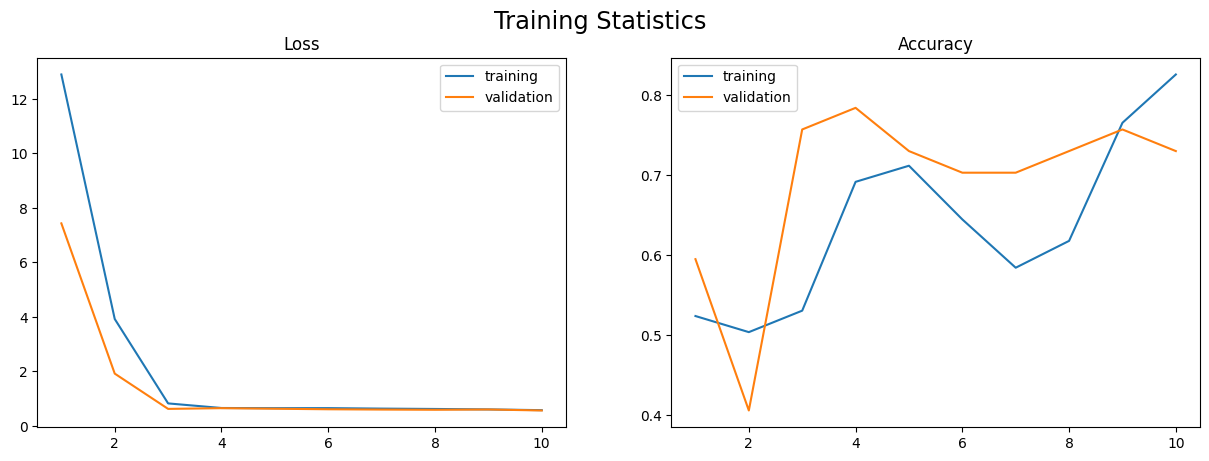

In [18]:
# Set the experiment name and create an MLflow run
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name = run_name) as mlflow_run:
    
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("dataset", "cat_dog")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("input_shape", input_shape)

    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    # Log an artifact (e.g., a plot)
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    x_axis = np.arange(1, num_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('Training Statistics', fontsize='xx-large')
    fig.set_figwidth(15)

    ax1.set_title('Loss')
    # ax1.set_yscale('log') 
    ax1.plot(x_axis, loss)
    ax1.plot(x_axis, val_loss)
    ax1.legend(['training', 'validation'])

    ax2.set_title('Accuracy')
    # ax2.set_yscale('log') 
    ax2.plot(x_axis, acc)
    ax2.plot(x_axis, val_acc)
    ax2.legend(['training', 'validation'])
    plt.savefig("plot.png")
    mlflow.log_artifact("plot.png")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

### Export MLFLow Artifacts to Sharepoint

In [21]:
# Save results to Sharepoint
sync.export_to_sharepoint()

2024-05-28 17:12:19,153 - INFO - Successfully copied to Sharepoint


## Model Validation

In [22]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "cat/Image_17.jpg"), target_size=input_shape
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

1/1 [==============================] - 0s 312ms/step
This image is 42.95% cat and 57.05% dog.


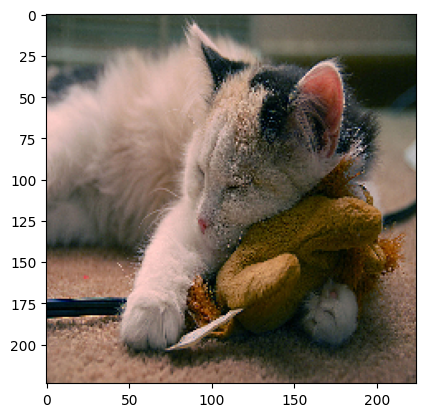

In [23]:
predictions = model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))